# 0 Imports

In [30]:
import pickle
import datetime
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt

from IPython.display        import Image
from IPython.core.display   import HTML

## 0.1 Funções Suporte

In [77]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

In [78]:
def estatistica_descritiva(df1):
    # Medidas de tendência central - Mean, Median
    media = pd.DataFrame(df1.apply(np.mean)).T
    mediana = pd.DataFrame(df1.apply(np.median)).T
    
    # Medidas de Dispersão - Std, min, max, range, skew, kurtosis
    desvio_padrao = pd.DataFrame(df1.apply(np.std)).T
    minimo = pd.DataFrame(df1.apply(np.min)).T
    maximo = pd.DataFrame(df1.apply(np.max)).T
    range = pd.DataFrame(df1.apply(lambda x : x.max() - x.min())).T
    assimetria = pd.DataFrame(df1.apply(lambda x : x.skew())).T
    curtosis = pd.DataFrame(df1.apply(lambda x : x.kurtosis())).T
    
    estatistica = pd.concat([minimo, maximo, range, media, mediana, desvio_padrao, assimetria, curtosis]).T.reset_index()
    estatistica.columns = ['variaveis','minimo', 'maximo', 'range', 'media', 'mediana', 'desvio_padrao', 'assimetria', 'curtosis']
    
    return estatistica

In [79]:
def visualizacao_dados_categoricos(df):
    for i in df:
        print(f'Atributo: {i} - {df[i].sort_values().unique().tolist()}\n')

In [ ]:
## Function to reduce the DF size
## It is necessary that after using this code, carefully check the output results for each column.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 10242
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 10242
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [80]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,10]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
def importar_arquivos()-> list:
    """
    Método para importar os DataFrames salvos no formato pkl.
    Por enquanto não vamos receber dados externos, mas no futuro isso será implementado.
    """
    
    arquivos = os.listdir(__CAMINHO_RAW)
    lista_arquivos = [arquivo for arquivo in arquivos if arquivo.endswith('.csv')]
    
    return lista_arquivos

In [ ]:
def mundaca_tipo_date(df: pd.DataFrame)-> pd.DataFrame:
    
    df['date'] = pd.to_datetime( df['date'] )
    
    return df

In [ ]:
def novas_colunas_date(df:pd.DataFrame)-> pd.DataFrame:
    # year
    df['year'] = df['date'].dt.year
    # month
    df['month'] = df['date'].dt.month
    # day
    df['day'] = df['date'].dt.day
    # week of year
    df['week_of_year'] = df['date'].dt.isocalendar().week
    # year week
    df['year_week'] = df['date'].dt.strftime('%Y-%W')
    # year month
    df['year_month'] = df['date'].dt.strftime('%Y-%m')

    df['data_br'] = df['date'].dt.strftime('%d/%m/%Y')
    
    return df

In [ ]:
def exportar_df(df: pd.DataFrame):
    df.to_pickle('../data/external/db_ajustado.pkl')

In [ ]:
def renomear_colunas(df: pd.DataFrame)-> pd.DataFrame:
    
    columns_old = df.columns
    snakecase = lambda x : inflection.underscore(x)
    columns_new = list(map(snakecase,columns_old))
    df.columns = columns_new
    
    return df

In [ ]:
def mesclar_arquivos(lista_arquivos: list,)-> pd.DataFrame:
    """
    Método para meclar os DataFrames. Aporveito para acrescentar 1 coluna de identificação da tabela.
    Preciso colocar essa identificação para não misturar os dados na hora da análise.
    """
    dfs = pd.DataFrame()
    for arquivo in lista_arquivos:
    
        df = pd.read_csv( os.path.join( __CAMINHO_RAW, arquivo ) )
        maquina = arquivo.split('_')[1]
        df['maquina'] = maquina
    
        df = renomear_colunas(df)
        df = mundaca_tipo_date(df)

        if dfs.empty:
            dfs = df
        else:
            if maquina in dfs['maquina'].values:

                date = dfs.loc[dfs['maquina'] == maquina, 'date']
                filtro = date.max()
                df = df.loc[df['date'] > filtro]
                
                dfs = pd.concat([dfs,df], ignore_index=True)
            else:
                dfs = pd.concat([dfs,df], ignore_index=True)

    return dfs

## 0.2 Load Data

In [31]:
__CAMINHO_RAW = '../data/raw/'
#__CAMINHO_RAW = 'E:/4_arquivos/1_projeto/modelo_unicin/src/data/raw'

__CAMINHO_INTERIM = '../data/processed'


,SubscriptionName,SubscriptionGuid,Date,ResourceGuid,ServiceName,ServiceType,ServiceRegion,ServiceResource,Quantity,Cost
125,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,10/1/2024,0ddb5c81-143d-52f8-9ea3-29b64cc0ef97,Backup,All,US East,GRS Data Stored,2.548416,0.114168


In [ ]:
lista_arquivos = importar_arquivos()

## 0.3 Ajuste primário

In [ ]:
df = mesclar_arquivos(lista_arquivos=lista_arquivos)

In [ ]:
df = novas_colunas_date(df)

# 1.0 Descrição dos Dados

# Data Sample

In [ ]:
df.sample(5)

## 1.2 Data Dimension

In [83]:
df.shape

(4728, 10)

## 1.3 Data Types

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4728 entries, 0 to 4727
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subscription_name  4728 non-null   object 
 1   subscription_guid  4728 non-null   object 
 2   date               4728 non-null   object 
 3   resource_guid      4728 non-null   object 
 4   service_name       4728 non-null   object 
 5   service_type       4728 non-null   object 
 6   service_region     4728 non-null   object 
 7   service_resource   4728 non-null   object 
 8   quantity           4728 non-null   float64
 9   cost               4728 non-null   float64
dtypes: float64(2), object(8)
memory usage: 369.5+ KB


In [10]:
df.isna().sum()

subscription_name    0
subscription_guid    0
date                 0
resource_guid        0
service_name         0
service_type         0
service_region       0
service_resource     0
quantity             0
cost                 0
dtype: int64

## 1.5 Estatística Descritiva

In [70]:
variaveis_categoricas = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])
variaveis_numericas = df.select_dtypes( include = ['int64','float64'])

### 1.5.1 Variáveis Numéricas

In [71]:
estatistica_numerica = estatistica_descritiva(variaveis_numericas)
estatistica_numerica

,variaveis,minimo,maximo,range,media,mediana,desvio_padrao,assimetria,curtosis
0,quantity,0.000000,169.057400,169.057400,6.477967,0.100008,12.700456,2.588009,11.655654
1,cost,0.000000,2.472096,2.472096,0.345307,0.006937,0.736648,2.017059,2.268850


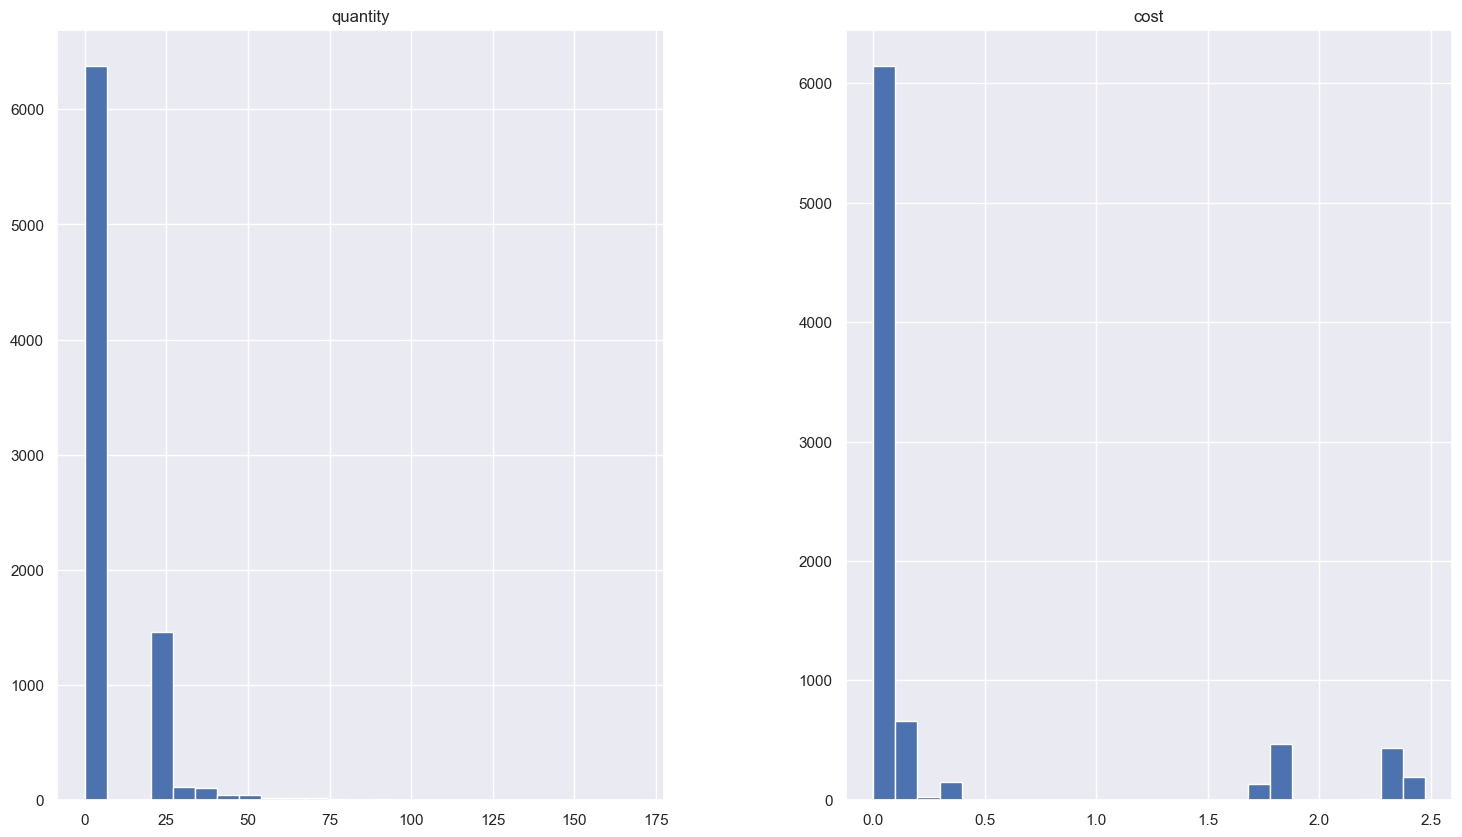

In [72]:
variaveis_numericas.hist(bins = 25);

### 1.5.2 Vairiáveis Categóricas

In [73]:
variaveis_categoricas.describe().T

,count,unique,top,freq
subscription_name,8205,1,Microsoft Azure Sponsorship,8205
subscription_guid,8205,1,0b1856f5-ffb1-4fb2-9b31-ebc3ddeacf68,8205
resource_guid,8205,29,40551b4c-e8be-48ed-b70b-f8d25c7de724,366
service_name,8205,9,Storage,3792
service_type,8205,14,All,1966
service_region,8205,6,All,4297
service_resource,8205,25,LRS Data Stored,1030


In [74]:
estatistica_categorica = visualizacao_dados_categoricos(variaveis_categoricas)
estatistica_categorica

Atributo: subscription_name - ['Microsoft Azure Sponsorship']

Atributo: subscription_guid - ['0b1856f5-ffb1-4fb2-9b31-ebc3ddeacf68']

Atributo: resource_guid - ['0b248445-aa24-4fe8-a794-a174929327bd', '0f68ed30-d33d-4b1b-8533-f16ae059f71d', '13c2d6a4-7f53-47a9-b6aa-8bb6167ac54d', '211e620c-ebcf-4db5-a7fd-996abebe9546', '26ce34b7-67b3-480d-9d1b-54a7fb80f67a', '28339581-90e9-4bde-93d2-a61b4f2a0b5e', '37a224be-47e1-42bd-b2aa-f08060e965ee', '3f2b1e1c-c886-4ec6-ad6f-dd0ef38819c9', '40551b4c-e8be-48ed-b70b-f8d25c7de724', '416a0a14-9d61-438f-a875-779e7b0e38c3', '42e2a22f-fabf-41ea-a21e-e86bb3ff5799', '43034668-a244-4031-bb4d-be5bcce22c5f', '5101ea73-2a5b-4120-b00e-30c13185e5a5', '839c4a20-9584-42af-a885-2798d1f027ba', '8f967c58-b144-4bd7-8882-8bf02767c839', '92f6f16a-1e67-4a1d-8271-9d9498d609a1', '95eca2c1-9519-4c55-baa1-9a0e0b201e25', '9995d93a-7d35-4d3f-9c69-7a7fea447ef4', 'a97f31a2-0fb1-4d64-bb43-a2399dd31f0b', 'ae331802-83a5-4b9e-b287-85675f794e3d', 'b9e5e77c-a0b3-4a2c-9b8b-57fa54f31c52'

# 1.6 Export PKL

In [17]:
exportar_df(df=df)